#Preparation

In [1]:
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from matplotlib.patches import Rectangle
import io
import copy

In [2]:
raw_data_file = files.upload() # upload the raw data from experiment 6

Saving E6-CloudSecurity-Data.xlsx to E6-CloudSecurity-Data.xlsx


In [3]:
xls = pd.ExcelFile('/content/E6-CloudSecurity-Data.xlsx')
raw_data = pd.read_excel(xls, 0)

In [4]:
helm_experiment_design = files.upload() # upload the data from the helm experiment design file

Saving Helm_Experiment_Design.xlsx to Helm_Experiment_Design.xlsx


In [5]:
xls2 = pd.ExcelFile('/content/Helm_Experiment_Design.xlsx')
exp_design = pd.read_excel(xls2, 0)

In [6]:
NUMBER_OF_TREATMENTS = 4 # number of tools
TREATMENT_LETTERS = ["A", "B", "C", "D"]
NUMBER_OF_CHARTS = 9 # Number of charts per group

# List of lists of charts containing the 4-tuple values. Ex: [["PRCM", "PNWN", ...], [...], ...].
# The lists inside the big list represent the treatments with the first one being treatment A.
# Each list contains the 9 charts with the 4 tuple values.
CHART_BY_TREATMENT = []
TOOL_BY_TREATMENT = [] #Same as the previous variable but for the tools. Ex: [["KICS", "Checkov", ...], [...], ...]
VIOLATED_BEGINNING_BY_TREATMENT = [] #Correction about the policies violated at the beginning for each chart for each treatment
MITIGATED_BY_TREATMENT = [] # Correction about the mitigations for each chart for each treatment
VIOLATED_END_BY_TREATMENT = [] # Correction about the policies violated at the end for each chart for each treatment
row_group = 1 # row number containing the first tuples

for treatment in range(NUMBER_OF_TREATMENTS):
  l_charts = []
  l_tools = []
  l_beginning = []
  l_mitigation = []
  l_ending = []
  for chart in range(NUMBER_OF_CHARTS):
    #CHART
    result = exp_design.iloc[row_group, chart + 1]
    result_list = result.split(", ")
    caracteristics = ["P", "R", "W", "C"]
    if result_list[0] != "present":
      caracteristics[0] = "A"
    if result_list[1] != "alert":
      caracteristics[1] = "N"
    if result_list[2] != "wrong":
      caracteristics[2] = "C"
    if result_list[3] == "namespace":
      caracteristics[3] = "S"
    else:
      caracteristics[3] = result_list[3][0].upper()
    l_charts.append(''.join(caracteristics))

    #TOOL
    result = exp_design.iloc[row_group + 2, chart + 1]
    l_tools.append(result)

    #BEGINNING
    result = exp_design.iloc[row_group + 3, chart + 1]
    l_beginning.append(result)

    #MITIGATION
    result = exp_design.iloc[row_group + 4, chart + 1]
    l_mitigation.append(result)

    #ENDING
    result = exp_design.iloc[row_group + 5, chart + 1]
    l_ending.append(result)

  CHART_BY_TREATMENT.append(l_charts)
  TOOL_BY_TREATMENT.append(l_tools)
  VIOLATED_BEGINNING_BY_TREATMENT.append(l_beginning)
  MITIGATED_BY_TREATMENT.append(l_mitigation)
  VIOLATED_END_BY_TREATMENT.append(l_ending)

  row_group += 7

#Variables to fine tune the intervention metrics
BONUS = 1
MALUS = 0.5
BONUS_M2 = 1
MALUS_M2 = 0.2

In [7]:
processed_data = {"SID": [], "Group": [], "Scenario": [], "DemoM1": [], "DemoM2": [], "IntervM1": [], "IntervM2": [], "PercM": []}

student_id = 1
for students in range(len(raw_data)):
  student_treatment = raw_data.loc[students, "Treatment"]
  column_first_chart = 9 + (ord(student_treatment) - ord('A')) * 28 # Column number containing the first question about the charts depending on the treatment

  #demographic variables
  d1_knowledge_bubernetes = raw_data.loc[students, "How familiar are you with Kubernetes and Helm Charts?   1 - Never used it before  2 - Somewhat familiar (used it few times)  3 - Really familiar (attended courses and used in a project)  4 - Expert (several projects or work experience) - Kubernetes"]
  d2_knowledge_helm = raw_data.loc[students, "How familiar are you with Kubernetes and Helm Charts?   1 - Never used it before  2 - Somewhat familiar (used it few times)  3 - Really familiar (attended courses and used in a project)  4 - Expert (several projects or work experience) - Helm Charts"]

  #perception variable
  percm = raw_data.loc[students, "Out of the tools that you used, select the one that you think performed better (e.g., in terms of number of misconfigurations found or less false negatives)."]

  #intervM1
  for chart in range(NUMBER_OF_CHARTS):
    if chart == 4: #to escape the column "what is the storage of the volumeClaimTemplates called data?"
      column_first_chart += 1

    #intervM1
    policies_beginning = raw_data.iloc[students, column_first_chart] # Answer of the question "What policies were violated at the beginning (original template file)?"
    policies_beginning_list = policies_beginning.split(',')
    policy_violated = VIOLATED_BEGINNING_BY_TREATMENT[ord(student_treatment) - ord('A')][chart] # the actual policy that was violated based on the correction from the template
    intervM1 = 0
    try:
      index = policies_beginning_list.index(policy_violated)
      policies_beginning_list.remove(policy_violated)
      intervM1 += BONUS
    except:
      pass
    intervM1 = (intervM1 - MALUS * len(policies_beginning_list)) * (30 * d1_knowledge_bubernetes / 100 + d2_knowledge_helm)

    #intervM2
    mitigation_student = raw_data.iloc[students, column_first_chart + 1] # Answer of the question "Were the mitigations implemented?"
    mitigation_correction = MITIGATED_BY_TREATMENT[ord(student_treatment) - ord('A')][chart] # The actual real answer from the correction
    policies_end = raw_data.iloc[students, column_first_chart + 2] #Answer of the question "What policies were violated at the end (fixed template file)?"
    policies_end_list = policies_end.split(',')
    policy_violated_end = VIOLATED_END_BY_TREATMENT[ord(student_treatment) - ord('A')][chart] #The actual real answer from the correction about the previous variable
    intervM2 = 0
    if mitigation_correction == mitigation_student:
      intervM2 = 3
    try:
      index = policies_end_list.index(policy_violated_end)
      policies_end_list.remove(policy_violated_end)
      intervM2 += BONUS_M2
    except:
      pass
    intervM2 -= len(policies_end_list) * MALUS_M2

    processed_data["SID"].append(student_id)
    processed_data["Group"].append(TOOL_BY_TREATMENT[ord(student_treatment) - ord('A')][chart])
    processed_data["Scenario"].append(CHART_BY_TREATMENT[ord(student_treatment) - ord('A')][chart][3])
    processed_data["DemoM1"].append(d1_knowledge_bubernetes)
    processed_data["DemoM2"].append(d2_knowledge_helm)
    processed_data["IntervM1"].append(intervM1)
    processed_data["IntervM2"].append(intervM2)
    if percm == "Checkov":
      processed_data["PercM"].append(1)
    elif percm == "KICS":
      processed_data["PercM"].append(2)
    else:
      processed_data["PercM"].append(3)

    column_first_chart += 3

  student_id += 1

In [8]:
df_processed_data = pd.DataFrame(processed_data)
df_processed_data.to_csv('processed_data.csv', mode='w', index=False, header=True)

CSV Fields
*   SID --> Student ID,  eg. A123
*   Group --> eg. Full/ Slice
*   Scenario --> eg. Vulnerability types: Path/ DOS/ SQL/ XSS
*   DemoMX --> Demographic Metrics, eg. Skills in Java, programming experience
*   IntervMX --> Metric of your choice, eg. Number of correctly identified vulnerability
*   PercM --> Perceived metric, eg. Perceived ML accuracy, if not applicable to the experiment set value NULL

### Read data from .csv

In [ ]:
data = pd.read_csv('/content/processed_data.csv')

In [ ]:
MIN_DEMO1 = 1
MAX_DEMO1 = 5
MIN_DEMO2 = 1
MAX_DEMO2 = 5

In [ ]:
MIN_INTERV1 = -5
MAX_INTERV1 = 5
MIN_INTERV2 = -5
MAX_INTERV2 = 5

In [ ]:
MIN_PERC = 1
MAX_PERC = 3

In [ ]:
GROUP_COLORS = {"A": "#3274A1", "B": '#E1812C', "C": '#3A923A'}

In [ ]:
SCENARIO_COLORS = {'C1':"turquoise", 'C2':"gold", 'C3':"orchid"}

# Demographic Analysis

## Histograms
Distributions of data (based on groups/ scenario)

In [ ]:
def produce_histogram(ax, data, group, groupVals, field, min, max, colors):
  if group == None:
    n, bins, patches = ax.hist(data[field], bins = np.arange(min-0.25, max+1.75, 1), rwidth=0.7, width=0.75)
    if field == "DemoM1" or field == "DemoM2" or field == "PercM":
      for i in range(len(patches.patches)):
        patches.patches[i].set(height = patches.patches[i].get_height() / 9)
    if field == "PercM":
      ax.bar_label(patches, labels = ["Checkov", "KICS", "Kubescape"], label_type = 'center')
    else:
      ax.bar_label(patches, fontsize=10)
  else:
    n, bins, patches = ax.hist(data[data[group] == groupVals[0]][field], bins = np.arange(min-0.25, max+1.75, 1), rwidth=0.7, color = colors[groupVals[0]], width=0.25)
    ax.bar_label(patches, fontsize=10)
    n, bins, patches = ax.hist(data[data[group] == groupVals[1]][field], bins = np.arange(min, max+2, 1), rwidth=0.7, color = colors[groupVals[1]], width=0.25)
    ax.bar_label(patches, fontsize=10)
    n, bins, patches = ax.hist(data[data[group] == groupVals[2]][field], bins = np.arange(min+0.25, max+2.25, 1), rwidth=0.7, color = colors[groupVals[2]], width=0.25)
    ax.bar_label(patches, fontsize=10)
  ax.set_xticks(np.arange(min+0.25, max+1.25, 1), np.arange(min, max+1, 1))
  ax.set_title(field)
  ax.set_xlim([min-0.5, max+1])
  return ax

### Demographic Histogram

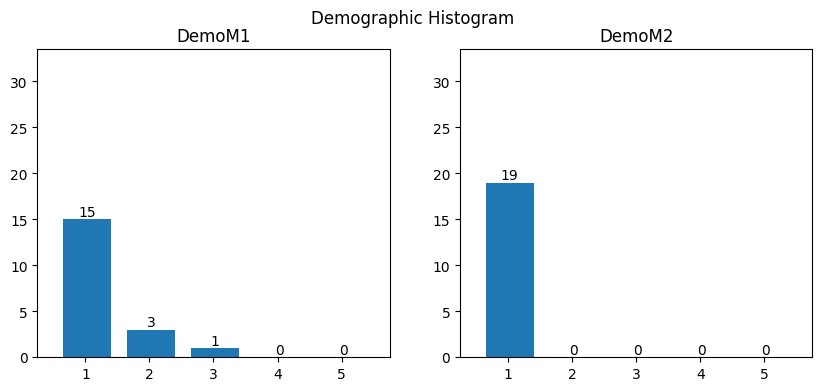

In [ ]:
max_ylim = (max(data.groupby(["DemoM1"])["SID"].count().max(), data.groupby(["DemoM2"])["SID"].count().max())) / 6 + 5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1 = produce_histogram(ax1, data, None, None, "DemoM1", MIN_DEMO1, MAX_DEMO1, GROUP_COLORS)
ax1.set_ylim([0,max_ylim])

ax2 = produce_histogram(ax2, data, None, None, "DemoM2", MIN_DEMO2, MAX_DEMO2, GROUP_COLORS)
ax2.set_ylim([0,max_ylim])

fig.suptitle("Demographic Histogram")
plt.show()

## Statistics about the demographic variables

In [ ]:
# Statistics about the demographic variables
mean_demoM1 = data["DemoM1"].mean()
median_demoM1 = data["DemoM1"].median()
stdev_demoM1 = data["DemoM1"].std()
mean_demoM2 = data["DemoM2"].mean()
median_demoM2 = data["DemoM2"].median()
stdev_demoM2 = data["DemoM2"].std()
print("Mean DemoM1: ", mean_demoM1)
print("Median DemoM1: ", median_demoM1)
print("Stdev DemoM1: ", stdev_demoM1)
print("Mean DemoM2: ", mean_demoM2)
print("Median DemoM2: ", median_demoM2)
print("Stdev DemoM2: ", stdev_demoM2)

Mean DemoM1:  1.263157894736842
Median DemoM1:  1.0
Stdev DemoM1:  0.5485697700107612
Mean DemoM2:  1.0
Median DemoM2:  1.0
Stdev DemoM2:  0.0


## Scatter plots
Represent values for two different numeric variables to compare the two variables.

In [ ]:
def scatter_plot(ax, data, group, groupVal, colors, first, second):
  if group == None:
    data_scatter = data
    color = "blue"
  else:
    data_scatter = data[data[group] == groupVal]
    color = colors[groupVal]

  a, ca = np.unique(np.c_[data_scatter[first],data_scatter[second]], return_counts=True, axis=0)
  ax.scatter(a[:,0],a[:,1],s=ca*50 / 9, c=color)

  if "Demo" in first:
    min1 = MIN_DEMO1
    max1 = MAX_DEMO1
  else:
    min1 = MIN_INTERV1
    max1 = MAX_INTERV1

  if "Demo" in second:
    min2 = MIN_DEMO2
    max2 = MAX_DEMO2
  else:
    min2 = MIN_INTERV2
    max2 = MAX_INTERV2

  ax.set_xticks(np.arange(min1, max1+1,1),np.arange(min1, max1+1,1))
  ax.set_yticks(np.arange(min2, max2+1,1),np.arange(min2, max2+1,1))
  if group is not None:
    ax.set_title(group + " " + groupVal)
  return ax

### Demographic Scatter Plot

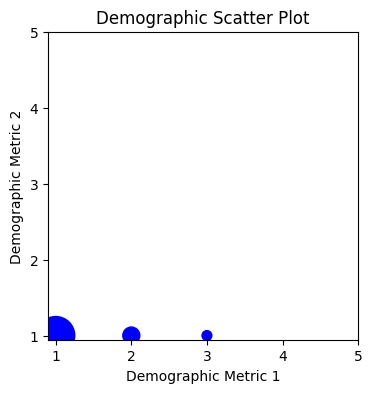

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax = scatter_plot(ax, data, None, None, GROUP_COLORS,"DemoM1", "DemoM2")

ax.set_xlabel("Demographic Metric 1")
ax.set_ylabel("Demographic Metric 2")

plt.title("Demographic Scatter Plot")
plt.show()

# Intervention Metrics

## Boxplots
A standardized way of displaying the dataset based on the five-number summary: the minimum, the maximum, the sample median, and the first and third quartiles.

### Intervention Boxplot by Group

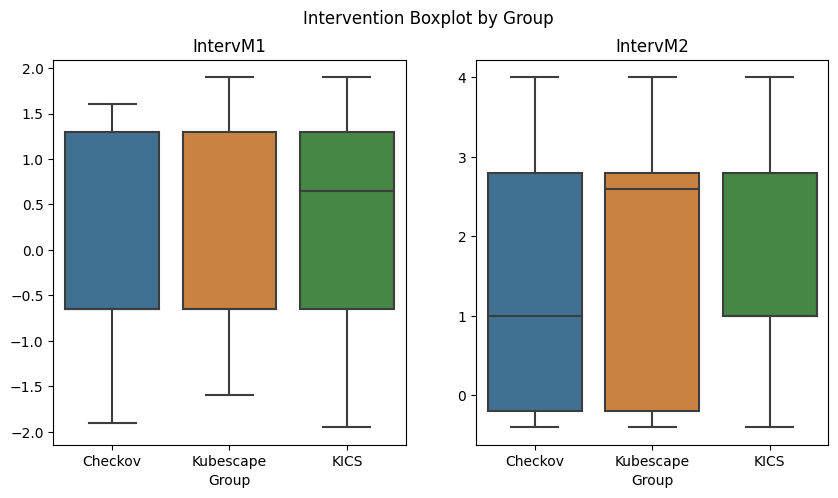

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.set_palette(palette=GROUP_COLORS.values())

sns.boxplot(x='Group', y='IntervM1', data=data, ax=axes[0])
axes[0].set_title("IntervM1")
axes[0].set_ylabel("")

sns.boxplot(x='Group', y='IntervM2', data=data, ax=axes[1])
axes[1].set_title("IntervM2")
axes[1].set_ylabel("")
axes[1].semilogy

fig.suptitle("Intervention Boxplot by Group")
plt.show()

## Statistics about the intervention metrics based on the groups

In [ ]:
mean_M1 = data.groupby("Group")["IntervM1"].mean()
median_M1 = data.groupby("Group")["IntervM1"].median()
stdev_M1 = data.groupby("Group")["IntervM1"].std()
mean_M2 = data.groupby("Group")["IntervM2"].mean()
median_M2 = data.groupby("Group")["IntervM2"].median()
stdev_M2 = data.groupby("Group")["IntervM2"].std()
print("Mean M1: ", mean_M1)
print("Median M1: ", median_M1)
print("Stdev M1: ", stdev_M1)
print("Mean M2: ", mean_M2)
print("Median M2: ", median_M2)
print("Stdev M2: ", stdev_M2)

Mean M1:  Group
Checkov      0.142982
KICS         0.385088
Kubescape    0.161404
Name: IntervM1, dtype: float64
Median M1:  Group
Checkov     -0.65
KICS         0.65
Kubescape   -0.65
Name: IntervM1, dtype: float64
Stdev M1:  Group
Checkov      0.987260
KICS         1.064188
Kubescape    1.058554
Name: IntervM1, dtype: float64
Mean M2:  Group
Checkov      1.305263
KICS         1.740351
Kubescape    1.726316
Name: IntervM2, dtype: float64
Median M2:  Group
Checkov      1.0
KICS         1.0
Kubescape    2.6
Name: IntervM2, dtype: float64
Stdev M2:  Group
Checkov      1.513324
KICS         1.429268
Kubescape    1.665461
Name: IntervM2, dtype: float64


### Intervention Boxplot by Scenario

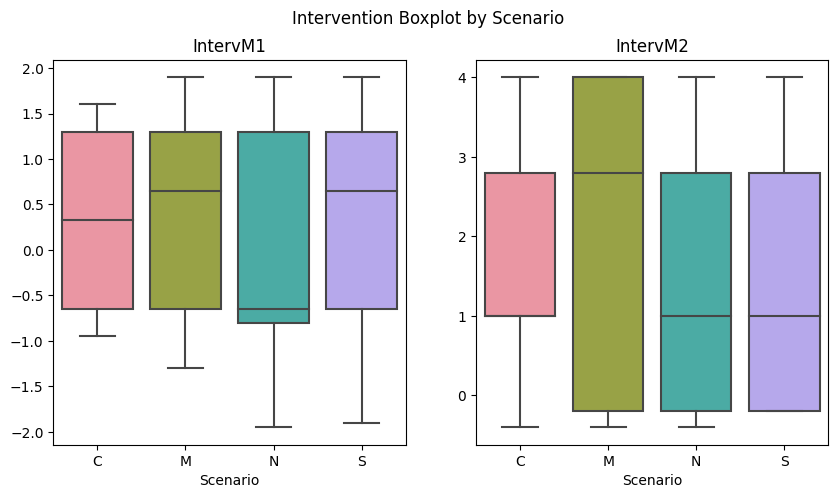

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.set_palette(palette=SCENARIO_COLORS.values())

sns.boxplot(x='Scenario', y='IntervM1', data=data, ax=axes[0])
axes[0].set_title("IntervM1")
axes[0].set_ylabel("")

sns.boxplot(x='Scenario', y='IntervM2', data=data, ax=axes[1])
axes[1].set_title("IntervM2")
axes[1].set_ylabel("")
axes[1].semilogy

fig.suptitle("Intervention Boxplot by Scenario")
plt.show()

In [ ]:
mean_M1 = data.groupby("Scenario")["IntervM1"].mean()
median_M1 = data.groupby("Scenario")["IntervM1"].median()
stdev_M1 = data.groupby("Scenario")["IntervM1"].std()
mean_M2 = data.groupby("Scenario")["IntervM2"].mean()
median_M2 = data.groupby("Scenario")["IntervM2"].median()
stdev_M2 = data.groupby("Scenario")["IntervM2"].std()
print("Mean M1: ", mean_M1)
print("Median M1: ", median_M1)
print("Stdev M1: ", stdev_M1)
print("Mean M2: ", mean_M2)
print("Median M2: ", median_M2)
print("Stdev M2: ", stdev_M2)

Mean M1:  Scenario
C    0.327500
M    0.351316
N   -0.037500
S    0.360976
Name: IntervM1, dtype: float64
Median M1:  Scenario
C    0.325
M    0.650
N   -0.650
S    0.650
Name: IntervM1, dtype: float64
Stdev M1:  Scenario
C    0.974742
M    0.974783
N    1.110903
S    1.028440
Name: IntervM1, dtype: float64
Mean M2:  Scenario
C    1.515000
M    2.063158
N    1.446154
S    1.409756
Name: IntervM2, dtype: float64
Median M2:  Scenario
C    1.0
M    2.8
N    1.0
S    1.0
Name: IntervM2, dtype: float64
Stdev M2:  Scenario
C    1.432865
M    1.888288
N    1.475879
S    1.329625
Name: IntervM2, dtype: float64


## Scatter plot

### Intervention Scatter Plot by Group

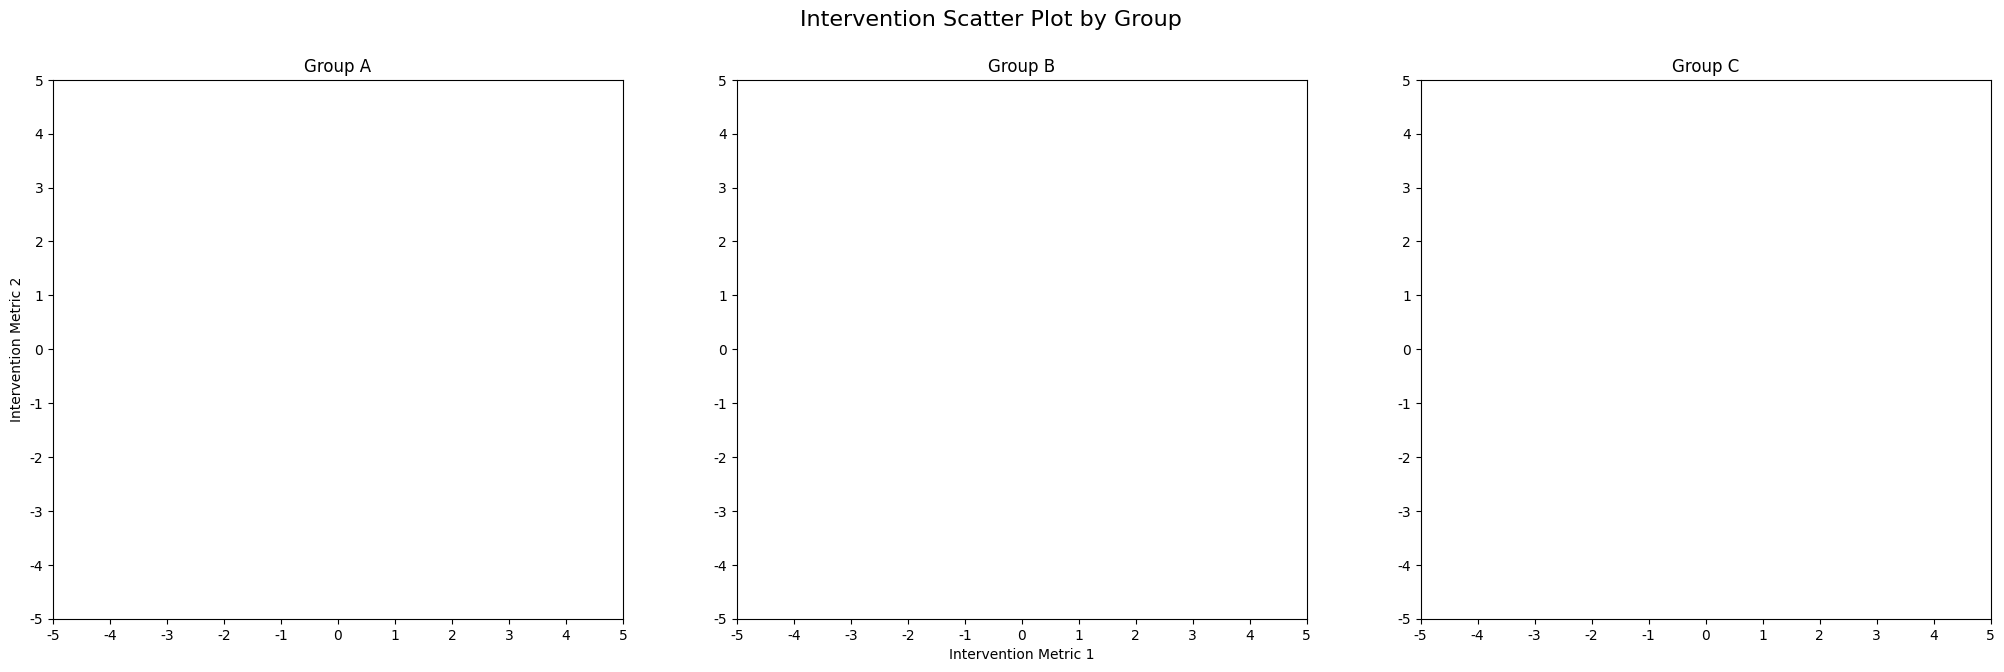

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))

ax1 = scatter_plot(ax1, data, "Group", "A", GROUP_COLORS, "IntervM1", "IntervM2")
ax2 = scatter_plot(ax2, data, "Group", "B", GROUP_COLORS, "IntervM1", "IntervM2")
ax3 = scatter_plot(ax3, data, "Group", "C", GROUP_COLORS, "IntervM1", "IntervM2")

ax2.set_xlabel("Intervention Metric 1")
ax1.set_ylabel("Intervention Metric 2")

fig.suptitle("Intervention Scatter Plot by Group",fontsize=16)
plt.show()

# Perception Metric

## Histograms

### Perception Histogram

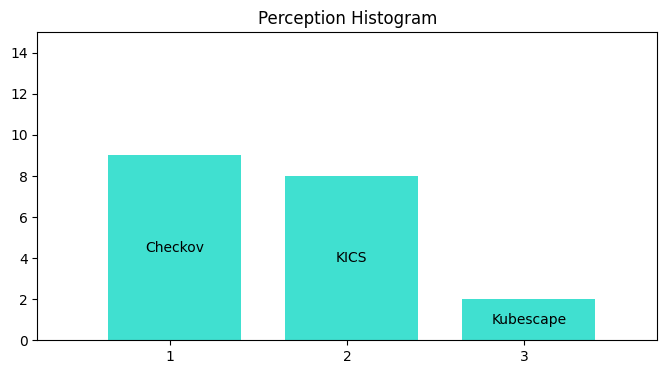

In [ ]:
max_ylim = data.groupby(["PercM"])["SID"].count().max() + 5

fig, ax = plt.subplots(figsize=(8, 4))

ax = produce_histogram(ax, data, None, None, "PercM", MIN_PERC, MAX_PERC, GROUP_COLORS)
ax.set_ylim([0,15])

plt.title("Perception Histogram")
plt.show()

## Boxplots

### Perception Boxplot by Group


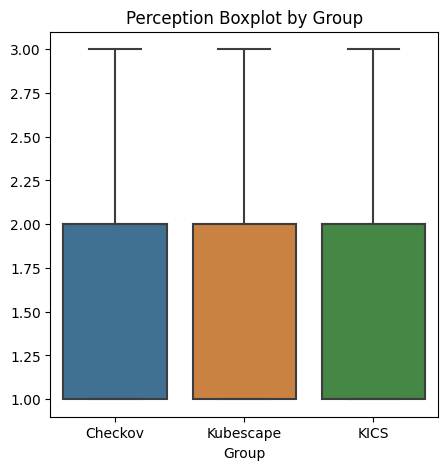

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.set_palette(palette=GROUP_COLORS.values())

sns.boxplot(x='Group', y='PercM', data=data, ax=ax)
ax.set_title("Perception Boxplot by Group")
ax.set_ylabel("")

plt.show()

### Perception Boxplot by Scenario

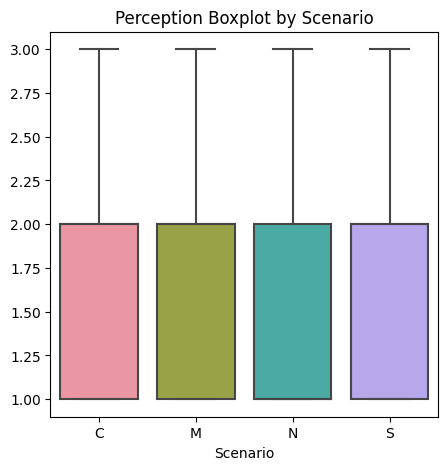

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.set_palette(palette=SCENARIO_COLORS.values())

sns.boxplot(x='Scenario', y='PercM', data=data, ax=ax)
ax.set_title("Perception Boxplot by Scenario")
ax.set_ylabel("")

plt.show()

# Statistical Test

# Analyze zero vs non-zero with Chi-square and Wilcoxon

In case your metrics determine an excess of zeros we need to split the analysis in two test:


1.   A test to determine an effect by a binary distinction: zero - non zero
2.   A test to determine an effect on the non-zero part of data. Ignoring in the analysis the zeros



In [ ]:
#define threshold for zero/non-zero or keep zero as the threshold
threshold_intervm1 = 0 #here your choice, it can also be zero
threshold_intervm2 = 2.6 #here your choice, it can also be zero

#all below threshold and equal is zero, else is non-zero
data_zero_non_zero = data.copy()
data_zero_non_zero.loc[data_zero_non_zero['IntervM1']<=threshold_intervm1,'IntervM1']=0
data_zero_non_zero.loc[data_zero_non_zero['IntervM1']>threshold_intervm1,'IntervM1']=1

data_zero_non_zero.loc[data_zero_non_zero['IntervM2']<=threshold_intervm2,'IntervM2']=0
data_zero_non_zero.loc[data_zero_non_zero['IntervM2']>threshold_intervm2,'IntervM2']=1

#chi-square test zero-non zero
contingency_table = pd.crosstab(data_zero_non_zero.Group, data_zero_non_zero.IntervM1)
print(contingency_table)
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f'Group x IntervM1 Chi_square value {chi2} p value {p} degrees of freedom {dof}')

contingency_table = pd.crosstab(data_zero_non_zero.Group, data_zero_non_zero.IntervM2)
print(contingency_table)
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f'Group x IntervM2 Chi_square value {chi2} p value {p} degrees of freedom {dof}')

contingency_table = pd.crosstab(data_zero_non_zero.Scenario, data_zero_non_zero.IntervM1)
print(contingency_table)
contingency_table = pd.crosstab(data_zero_non_zero.Scenario, data_zero_non_zero.IntervM2)
print(contingency_table)

IntervM1   0.0  1.0
Group              
Checkov     33   24
KICS        25   32
Kubescape   31   26
Group x IntervM1 Chi_square value 2.436832008769526 p value 0.2956981807820014 degrees of freedom 2
IntervM2   0.0  1.0
Group              
Checkov     40   17
KICS        37   20
Kubescape   29   28
Group x IntervM2 Chi_square value 4.8148040638606675 p value 0.09004893520375232 degrees of freedom 2
IntervM1  0.0  1.0
Scenario          
C          20   20
M          18   20
N          31   21
S          20   21
IntervM2  0.0  1.0
Scenario          
C          26   14
M          17   21
N          36   16
S          27   14


Inspect only non-zero values using Wilcoxon

In [ ]:
#ignore zero values

data_nonzero_intervm1 = data[data['IntervM1']>threshold_intervm1]
data_nonzero_intervm2 = data[data['IntervM2']>threshold_intervm2]

from itertools import combinations

#groups do not change
group_pairs = list(combinations(data["Group"].unique(), 2))

my_groups = data_nonzero_intervm1["Group"].unique()

#A vs B
stat, p = stats.ranksums(x=data_nonzero_intervm1[data_nonzero_intervm1.Group == my_groups[0]]['IntervM1'], y=data_nonzero_intervm1[data_nonzero_intervm1.Group == my_groups[1]]['IntervM1'], alternative = 'two-sided')
print("{} Group {} x Group {} stat = {}, p-value = {}".format('IntervM1', my_groups[0], my_groups[1],stat, p))
#A vs C
stat, p = stats.ranksums(x=data_nonzero_intervm1[data_nonzero_intervm1.Group == my_groups[0]]['IntervM1'], y=data_nonzero_intervm1[data_nonzero_intervm1.Group == my_groups[2]]['IntervM1'], alternative = 'two-sided')
print("{} Group {} x Group {} stat = {}, p-value = {}".format('IntervM1', my_groups[0], my_groups[2],stat, p))

#same for intervM2
my_groups = data_nonzero_intervm2["Group"].unique()

stat, p = stats.ranksums(x=data_nonzero_intervm2[data_nonzero_intervm2.Group == my_groups[0]]['IntervM2'], y=data_nonzero_intervm2[data_nonzero_intervm2.Group == my_groups[1]]['IntervM2'], alternative = 'two-sided')
print("{} Group {} x Group {} stat = {}, p-value = {}".format('IntervM2', my_groups[0], my_groups[1],stat, p))

stat, p = stats.ranksums(x=data_nonzero_intervm2[data_nonzero_intervm2.Group == my_groups[0]]['IntervM2'], y=data_nonzero_intervm2[data_nonzero_intervm2.Group == my_groups[2]]['IntervM2'], alternative = 'two-sided')
print("{} Group {} x Group {} stat = {}, p-value = {}".format('IntervM2', my_groups[0], my_groups[2],stat, p))


IntervM1 Group Kubescape x Group Checkov stat = 0.048545977336288584, p-value = 0.9612811229977414
IntervM1 Group Kubescape x Group KICS stat = -0.00781759123547031, p-value = 0.9937625281841856
IntervM2 Group Checkov x Group Kubescape stat = 0.43309179819425675, p-value = 0.6649480810337709
IntervM2 Group Checkov x Group KICS stat = 0.33523708167324295, p-value = 0.7374462516595328


## If data is ordinal, perform Wilcoxon Ranksum Tests

In case we do not have an excess of zeros we can directly apply Wilcoxon if ordinal

In [ ]:
from itertools import combinations

my_groups = data["Group"].unique()

#A vs B
stat, p = stats.ranksums(x=data[data.Group == my_groups[0]]['IntervM1'], y=data[data.Group == my_groups[1]]['IntervM1'], alternative = 'two-sided')
print("{} Group {} x Group {} stat = {}, p-value = {}".format('IntervM1', my_groups[0], my_groups[1],stat, p))
#A vs C
stat, p = stats.ranksums(x=data[data.Group == my_groups[0]]['IntervM1'], y=data[data.Group == my_groups[2]]['IntervM1'], alternative = 'two-sided')
print("{} Group {} x Group {} stat = {}, p-value = {}".format('IntervM1', my_groups[0], my_groups[2],stat, p))

#same for intervM2
stat, p = stats.ranksums(x=data[data.Group == my_groups[0]]['IntervM2'], y=data[data.Group == my_groups[1]]['IntervM2'], alternative = 'two-sided')
print("{} Group {} x Group {} stat = {}, p-value = {}".format('IntervM2', my_groups[0], my_groups[1],stat, p))

stat, p = stats.ranksums(x=data[data.Group == my_groups[0]]['IntervM2'], y=data[data.Group == my_groups[2]]['IntervM2'], alternative = 'two-sided')
print("{} Group {} x Group {} stat = {}, p-value = {}".format('IntervM2', my_groups[0], my_groups[2],stat, p))

IntervM1 Group Checkov x Group Kubescape stat = 0.03967024541481219, p-value = 0.9683560237150757
IntervM1 Group Checkov x Group KICS stat = -1.0115912580777109, p-value = 0.3117335274307751
IntervM2 Group Checkov x Group Kubescape stat = -1.1306019943221475, p-value = 0.258222647741568
IntervM2 Group Checkov x Group KICS stat = -1.4819670251390555, p-value = 0.13834906917254605


In [ ]:
from itertools import combinations

scenario_pairs = list(combinations(data["Scenario"].unique(), 2))

for pair in scenario_pairs:
  stat, p = stats.ranksums(x=data[data.Scenario == pair[0]]['IntervM1'], y=data[data.Scenario == pair[1]]['IntervM1'], alternative = 'two-sided')
  print("{} Scenario {} x Scenario {} stat = {}, p-value = {}".format('IntervM1', pair[0], pair[1],stat, p))

# droping all the rows containing Nan in the metric 2, otherwise we cannot compute the p-value between the scenarios
tmp = data.drop(columns=["PercM"])
data2 = tmp.dropna()
for pair in scenario_pairs:
  stat, p = stats.ranksums(x=data2[data2.Scenario == pair[0]]['IntervM2'], y=data2[data2.Scenario == pair[1]]['IntervM2'], alternative = 'two-sided')
  print("{} Scenario {} x Scenario {} stat = {}, p-value = {}".format('IntervM2', pair[0], pair[1],stat, p))

IntervM1 Scenario C x Scenario M stat = -0.11496168582269141, p-value = 0.9084754909226396
IntervM1 Scenario C x Scenario N stat = 1.9651152738967335, p-value = 0.049400897186723955
IntervM1 Scenario C x Scenario S stat = -0.0141694512666125, p-value = 0.9886947918980028
IntervM1 Scenario M x Scenario N stat = 2.0055244140793342, p-value = 0.04490701340764886
IntervM1 Scenario M x Scenario S stat = 0.0834028379380656, p-value = 0.933531232027727
IntervM1 Scenario N x Scenario S stat = -1.8648767676895748, p-value = 0.06219867958819506
IntervM2 Scenario C x Scenario M stat = -1.1946018657227497, p-value = 0.23224261996067808
IntervM2 Scenario C x Scenario N stat = 0.4646965978352997, p-value = 0.6421487450751022
IntervM2 Scenario C x Scenario S stat = 0.3400668303987, p-value = 0.7338062002424635
IntervM2 Scenario M x Scenario N stat = 1.7931267164578977, p-value = 0.07295266459868426
IntervM2 Scenario M x Scenario S stat = 1.5993720686946697, p-value = 0.10973795471974525
IntervM2 Scen

## If data is binary, perform Chi-Square Test.

In case we do not have an excess of zeros we can directly apply Chi-Square if binary

In [ ]:
contingency_table = pd.crosstab(data.Group, data.IntervM1)
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f'Group x IntervM1 Chi_square value {chi2} p value {p} degrees of freedom {dof}')

contingency_table = pd.crosstab(data.Group, data.IntervM2)
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f'Group x IntervM2 Chi_square value {chi2} p value {p} degrees of freedom {dof}')

contingency_table = pd.crosstab(data.Scenario, data.IntervM1)
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f'Scenario x IntervM1 Chi_square value {chi2} p value {p} degrees of freedom {dof}')

contingency_table = pd.crosstab(data.Scenario, data.IntervM2)
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f'Scenario x IntervM2 Chi_square value {chi2} p value {p} degrees of freedom {dof}')

Group x IntervM1 Chi_square value 21.342352843691977 p value 0.2624940509456583 degrees of freedom 18
Group x IntervM2 Chi_square value 45.58561967706285 p value 0.2509896479376437 degrees of freedom 40
Scenario x IntervM1 Chi_square value 84.40236763114956 p value 0.0003394351148476823 degrees of freedom 45
Scenario x IntervM2 Chi_square value 341.98274771000786 p value 3.2829922298054875e-28 degrees of freedom 100


# [OPTIONAL] Additional analysis
This is free for students to add additional analysis and plots